# 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

In [1]:
import pandas as pd
import sentencepiece as spm
import tensorflow as tf
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
# ✅ 데이터 로드 및 전처리
# 네이버 영화 리뷰 데이터셋을 로드하고 전처리하는 과정
train_txt = '/Users/jian_lee/Desktop/aiffel/data/text_process/Data/ratings_train.txt'
test_txt = '/Users/jian_lee/Desktop/aiffel/data/text_process/Data/ratings_test.txt'

def load_data(file):
    """
    텍스트 파일을 로드하여 DataFrame으로 변환하는 함수
    - 첫 번째 컬럼은 id, 두 번째 컬럼은 리뷰 내용(document), 세 번째 컬럼은 라벨(label)이다.
    - 첫 줄은 헤더이므로 제거하고, id 컬럼은 사용하지 않는다.
    - 결측치를 제거하고 데이터를 랜덤하게 섞는다.
    """
    df = pd.read_csv(file, delimiter='\t', names=['id', 'document', 'label'], skiprows=1)
    df.dropna(inplace=True)  # 결측치 제거
    df = df.sample(frac=1).reset_index(drop=True)  # 데이터 랜덤 섞기
    return df

# 훈련 및 테스트 데이터 로드
train_data = load_data(train_txt)
test_data = load_data(test_txt)

print(f"Train Data: {train_data.shape}")
print(f"Test Data: {test_data.shape}")

Train Data: (149995, 3)
Test Data: (49997, 3)


In [3]:
# ✅ SentencePiece 모델 학습
# 텍스트 데이터를 SentencePiece 모델을 이용하여 토큰화하기 위해 학습을 진행한다.
sp_model_prefix = 'spm_review'  # SentencePiece 모델 파일 이름
sp_model_path = f'{sp_model_prefix}.model'  # SentencePiece 모델 저장 경로
sp_vocab_size = 8000  # 단어 집합 크기

# SentencePiece 모델이 존재하지 않으면 학습을 진행
if not os.path.exists(sp_model_path):
    with open('spm_input.txt', 'w', encoding='utf-8') as f:
        for text in train_data['document']:
            f.write(text + '\n')  # 각 문장을 개행 문자로 구분하여 저장

    spm.SentencePieceTrainer.Train(
        input='spm_input.txt',  # 학습할 텍스트 데이터 파일 경로
        model_prefix=sp_model_prefix,  # 생성될 모델의 접두사
        vocab_size=sp_vocab_size,  # 단어 집합 크기
        model_type='bpe',  # 사용할 모델 유형 (unigram, bpe, char, word 선택 가능)
        character_coverage=0.9995,  # 한국어 데이터 처리를 위한 문자 커버리지 설정
    )

In [4]:
# ✅ SentencePiece 토크나이저 적용
# 학습된 SentencePiece 모델을 불러와서 문장을 토큰화한다.
sp = spm.SentencePieceProcessor()
sp.Load(sp_model_path)

def sp_tokenize(text, sp):
    """
    SentencePiece 모델을 사용하여 텍스트를 토큰화하는 함수
    - 입력: 문자열(문장)
    - 출력: 토큰화된 정수 리스트
    """
    return sp.EncodeAsIds(text)

def tokenize_data(data, sp):
    """
    데이터셋을 SentencePiece 토크나이저로 변환하는 함수
    - 입력: pandas DataFrame (텍스트와 라벨 포함)
    - 출력: 토큰화된 텍스트 리스트와 라벨 리스트
    """
    tokenized_texts = [sp_tokenize(text, sp) for text in data['document']]
    labels = data['label'].values
    return tokenized_texts, labels

# 훈련 및 테스트 데이터 토큰화
train_texts, train_labels = tokenize_data(train_data, sp)
test_texts, test_labels = tokenize_data(test_data, sp)

In [5]:
# ✅ 패딩 처리
# 모델 입력 크기를 일정하게 맞추기 위해 패딩을 적용한다.
max_len = 100
train_texts = pad_sequences(train_texts, maxlen=max_len, padding='post')
test_texts = pad_sequences(test_texts, maxlen=max_len, padding='post')

In [6]:
# ✅ PyTorch 기반 모델 학습
# LSTM 기반 감정 분석 모델을 학습하고 결과를 시각화한다.

# PyTorch 데이터셋 및 데이터로더 생성
# 데이터를 PyTorch 텐서로 변환하고 배치 처리를 위한 DataLoader를 구성
train_texts_tensor = torch.tensor(train_texts, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_texts_tensor = torch.tensor(test_texts, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# 훈련 데이터와 검증 데이터를 분리 (8:2 비율)
train_size = int(0.8 * len(train_texts_tensor))
val_size = len(train_texts_tensor) - train_size

# 랜덤 분할을 위한 인덱스 생성
indices = torch.randperm(len(train_texts_tensor))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# 훈련, 검증 데이터셋 생성
train_dataset = TensorDataset(
    train_texts_tensor[train_indices], 
    train_labels_tensor[train_indices]
)
val_dataset = TensorDataset(
    train_texts_tensor[val_indices], 
    train_labels_tensor[val_indices]
)
test_dataset = TensorDataset(test_texts_tensor, test_labels_tensor)

# 배치 크기 설정 및 DataLoader 생성
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
# LSTM 모델 정의
class SentimentLSTM(nn.Module):
    """
    감정 분석을 위한 LSTM 모델 클래스
    - 임베딩 레이어: 토큰을 밀집 벡터로 변환
    - LSTM 레이어: 문맥 정보를 캡처
    - 선형 레이어: 최종 감정 분류 수행
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout_rate=0.5):
        """
        LSTM 모델 초기화
        - vocab_size: 어휘 사전 크기 (SentencePiece 모델에서 학습된 토큰 개수)
        - embedding_dim: 임베딩 벡터 차원
        - hidden_dim: LSTM 은닉층 차원
        - n_layers: LSTM 레이어 수
        - dropout_rate: 드롭아웃 비율 (과적합 방지)
        """
        super(SentimentLSTM, self).__init__()
        
        # 임베딩 레이어: 텍스트 토큰을 고정 크기 벡터로 변환
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM 레이어: 문맥 정보를 학습, bidirectional=True로 양방향 학습 가능
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=n_layers, 
            bidirectional=True, 
            dropout=dropout_rate if n_layers > 1 else 0,
            batch_first=True
        )
        
        # 드롭아웃 레이어: 과적합 방지
        self.dropout = nn.Dropout(dropout_rate)
        
        # 출력 레이어: 이진 분류를 위한 선형 레이어
        # hidden_dim * 2는 양방향 LSTM의 출력 차원
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
        # 시그모이드 활성화 함수: 출력을 0-1 사이 확률로 변환
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, text):
        """
        순전파 함수: 입력 텍스트에서 감정 예측
        - text: 토큰화된 텍스트 텐서 [batch_size, seq_len]
        - 출력: 긍정(1)일 확률 [batch_size, 1]
        """
        # 텍스트를 임베딩 벡터로 변환 [batch_size, seq_len, embedding_dim]
        embedded = self.embedding(text)
        
        # LSTM 통과 [batch_size, seq_len, hidden_dim * 2]
        # packed_output에는 모든 시퀀스의 모든 타임스텝에 대한 출력이 포함됨
        packed_output, (hidden, cell) = self.lstm(embedded)
        
        # hidden: [num_layers * 2, batch_size, hidden_dim]
        # 마지막 레이어의 마지막 타임스텝 은닉 상태 추출
        # 양방향이므로 forward와 backward 방향의 은닉 상태를 연결
        # hidden[-2, :, :]: 마지막 레이어의 forward 방향 은닉 상태
        # hidden[-1, :, :]: 마지막 레이어의 backward 방향 은닉 상태
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        
        # 드롭아웃 적용
        hidden = self.dropout(hidden)
        
        # 선형 레이어로 감정 예측
        output = self.fc(hidden)
        
        # 확률로 변환
        return self.sigmoid(output)

In [8]:
# 모델 하이퍼파라미터 설정
vocab_size = sp_vocab_size + 1  # <unk> 토큰 포함
embedding_dim = 300  # 임베딩 차원
hidden_dim = 256  # LSTM 은닉층 차원
n_layers = 2  # LSTM 레이어 수
dropout_rate = 0.5  # 드롭아웃 비율

# 모델, 손실 함수, 옵티마이저 초기화
device = torch.device("mps" if torch.backends.mps.is_available() 
                      else ("cuda" if torch.cuda.is_available() else "cpu"))

print(f"✅ Using device: {device}")

model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, n_layers, dropout_rate)
model = model.to(device)

# 이진 교차 엔트로피 손실 함수
criterion = nn.BCELoss()
# Adam 옵티마이저 (학습률: 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

✅ Using device: mps


In [9]:
# 학습 함수 정의
def train_epoch(model, data_loader, optimizer, criterion, device):
    """
    한 에폭 동안 모델을 학습시키는 함수
    - model: 학습할 모델
    - data_loader: 학습 데이터 로더
    - optimizer: 가중치 업데이트를 위한 옵티마이저
    - criterion: 손실 함수
    - device: 학습 장치 (CPU 또는 GPU)
    - 반환값: 평균 손실, 정확도
    """
    model.train()  # 모델을 학습 모드로 설정
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for texts, labels in data_loader:
        # 데이터를 device로 이동
        texts = texts.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        # 그라디언트 초기화
        optimizer.zero_grad()
        
        # 순전파
        predictions = model(texts)
        
        # 손실 계산
        loss = criterion(predictions, labels)
        
        # 역전파
        loss.backward()
        
        # 가중치 업데이트
        optimizer.step()
        
        # 통계 업데이트
        total_loss += loss.item()
        predicted_labels = (predictions >= 0.5).int()
        correct_predictions += (predicted_labels == labels.int()).sum().item()
        total_predictions += labels.size(0)
    
    # 에폭 평균 손실 및 정확도 계산
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

In [10]:
# 평가 함수 정의
def evaluate(model, data_loader, criterion, device):
    """
    모델을 평가하는 함수
    - model: 평가할 모델
    - data_loader: 평가 데이터 로더
    - criterion: 손실 함수
    - device: 평가 장치 (CPU 또는 GPU)
    - 반환값: 평균 손실, 정확도
    """
    model.eval()  # 모델을 평가 모드로 설정
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():  # 그라디언트 계산 비활성화
        for texts, labels in data_loader:
            # 데이터를 device로 이동
            texts = texts.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            # 순전파
            predictions = model(texts)
            
            # 손실 계산
            loss = criterion(predictions, labels)
            
            # 통계 업데이트
            total_loss += loss.item()
            predicted_labels = (predictions >= 0.5).int()
            correct_predictions += (predicted_labels == labels.int()).sum().item()
            total_predictions += labels.size(0)
    
    # 평균 손실 및 정확도 계산
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

In [11]:
# 학습 실행
epochs = 5  # 에폭 수
train_losses = []  # 학습 손실 기록
train_accuracies = []  # 학습 정확도 기록
val_losses = []  # 검증 손실 기록
val_accuracies = []  # 검증 정확도 기록

best_val_loss = float('inf')  # 최적 검증 손실 초기화
best_model_path = 'best_sentiment_model.pt'  # 최적 모델 저장 경로

for epoch in range(epochs):
    # 학습 수행
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # 검증 수행
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # 최적 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch+1}: Best model saved with validation loss: {val_loss:.4f}")
    
    # 결과 출력
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\tVal Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

Epoch 1: Best model saved with validation loss: 0.3528
Epoch 1/5
	Train Loss: 0.4310 | Train Acc: 79.52%
	Val Loss: 0.3528 | Val Acc: 84.66%
Epoch 2: Best model saved with validation loss: 0.3282
Epoch 2/5
	Train Loss: 0.2996 | Train Acc: 87.23%
	Val Loss: 0.3282 | Val Acc: 85.89%
Epoch 3/5
	Train Loss: 0.2383 | Train Acc: 90.14%
	Val Loss: 0.3508 | Val Acc: 85.25%
Epoch 4/5
	Train Loss: 0.1765 | Train Acc: 92.91%
	Val Loss: 0.3821 | Val Acc: 85.44%
Epoch 5/5
	Train Loss: 0.1233 | Train Acc: 95.18%
	Val Loss: 0.4625 | Val Acc: 84.87%


In [12]:
# 최적 모델 로드
model.load_state_dict(torch.load(best_model_path))

# 테스트 데이터 평가
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 0.3289 | Test Acc: 85.78%


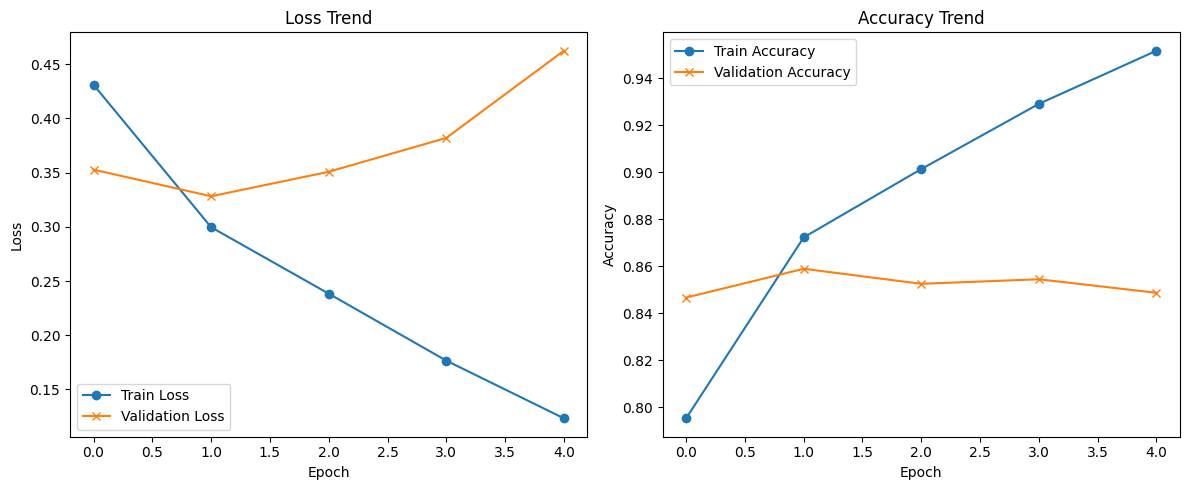

In [13]:
# ✅ 시각화: 학습 과정의 Loss 및 Accuracy 변화
# Loss와 Accuracy를 그래프로 시각화하여 학습 과정을 확인할 수 있도록 한다.
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    """
    학습 과정의 손실(Loss) 및 정확도(Accuracy) 변화를 시각화하는 함수
    - 입력: train_losses (학습 손실 리스트), train_accuracies (학습 정확도 리스트),
           val_losses (검증 손실 리스트), val_accuracies (검증 정확도 리스트)
    - 출력: 손실 및 정확도 변화 그래프
    """
    plt.figure(figsize=(12, 5))
    
    # Loss 시각화
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trend')
    plt.legend()
    
    # Accuracy 시각화
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Trend')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 시각화 실행
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

In [14]:
# ✅ 예측 함수 정의
def predict_sentiment(text, model, sp, device, max_len=100):
    """
    새로운 텍스트의 감정을 예측하는 함수
    - text: 예측할 텍스트
    - model: 학습된 모델
    - sp: SentencePiece 프로세서
    - device: 예측 장치 (CPU 또는 GPU)
    - max_len: 최대 시퀀스 길이
    - 반환값: 예측된 감정 (0: 부정, 1: 긍정), 긍정 확률
    """
    model.eval()  # 모델을 평가 모드로 설정
    
    # 텍스트 토큰화
    tokens = sp.EncodeAsIds(text)
    
    # 패딩 추가
    if len(tokens) < max_len:
        tokens = tokens + [0] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len]
    
    # 텐서로 변환
    tokens_tensor = torch.tensor(tokens).unsqueeze(0).to(device)  # [1, max_len]
    
    # 예측
    with torch.no_grad():
        prediction = model(tokens_tensor)
    
    # 결과 반환
    prob = prediction.item()
    sentiment = 1 if prob >= 0.5 else 0
    
    return sentiment, prob

# 예제 텍스트로 예측 테스트
example_texts = [
    "이 영화는 정말 재미있었어요. 배우들의 연기도 훌륭했고 스토리도 좋았습니다.",
    "시간 낭비였습니다. 스토리도 엉망이고 배우들의 연기도 별로였어요.",
    "그럭저럭 볼만했어요. 특별히 좋지도 나쁘지도 않았습니다."
]

print("\n예제 텍스트 감정 예측:")
for text in example_texts:
    sentiment, prob = predict_sentiment(text, model, sp, device)
    print(f"텍스트: {text}")
    print(f"예측: {'긍정' if sentiment == 1 else '부정'} (확률: {prob:.4f})\n")


예제 텍스트 감정 예측:
텍스트: 이 영화는 정말 재미있었어요. 배우들의 연기도 훌륭했고 스토리도 좋았습니다.
예측: 긍정 (확률: 0.9898)

텍스트: 시간 낭비였습니다. 스토리도 엉망이고 배우들의 연기도 별로였어요.
예측: 부정 (확률: 0.0025)

텍스트: 그럭저럭 볼만했어요. 특별히 좋지도 나쁘지도 않았습니다.
예측: 긍정 (확률: 0.6570)



In [15]:
# ✅ 모델 성능 추가 분석
# 모델의 오분류 사례를 분석하여 향후 개선점을 찾는다.
def analyze_misclassifications(model, data_loader, sp, device, num_samples=5):
    """
    모델이 잘못 분류한 예제를 분석하는 함수
    - model: 평가할 모델
    - data_loader: 평가 데이터 로더
    - sp: SentencePiece 프로세서
    - device: 평가 장치 (CPU 또는 GPU)
    - num_samples: 보여줄 오분류 샘플 수
    """
    model.eval()  # 모델을 평가 모드로 설정
    misclassified = []
    
    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device)
            labels = labels.to(device)
            
            # 예측
            predictions = model(texts)
            predicted_labels = (predictions >= 0.5).int().squeeze()
            
            # 오분류 식별
            for i, (text, label, pred, prob) in enumerate(zip(texts, labels, predicted_labels, predictions)):
                if label.item() != pred.item() and len(misclassified) < num_samples:
                    # SentencePiece로 디코딩하여 원래 텍스트 복원 시도
                    # 실제로는 원본 데이터셋에서 해당 인덱스의 텍스트를 가져오는 것이 더 정확함
                    text_ids = text.cpu().numpy()
                    # 패딩(0)을 제외한 실제 토큰 ID만 추출
                    text_ids = text_ids[text_ids != 0]
                    decoded_text = sp.DecodeIds(text_ids.tolist())
                    
                    misclassified.append({
                        'text': decoded_text,
                        'true_label': label.item(),
                        'predicted': pred.item(),
                        'probability': prob.item()
                    })
    
    # 오분류 샘플 출력
    print("\n오분류 샘플 분석:")
    for i, sample in enumerate(misclassified, 1):
        print(f"샘플 {i}:")
        print(f"텍스트: {sample['text']}")
        print(f"실제 라벨: {'긍정' if sample['true_label'] == 1 else '부정'}")
        print(f"예측 라벨: {'긍정' if sample['predicted'] == 1 else '부정'}")
        print(f"예측 확률: {sample['probability']:.4f}")
        print()

# 오분류 분석 실행
analyze_misclassifications(model, test_loader, sp, device)

# 학습 완료 메시지
print("모델 학습 및 평가가 완료되었습니다.")


오분류 샘플 분석:
샘플 1:
텍스트: 영화는 마무리를 잘해야 해-_-b
실제 라벨: 긍정
예측 라벨: 부정
예측 확률: 0.3785

샘플 2:
텍스트: Always Missing You - 이 노래때문에 별 다섯개 준다. 존나 고맙지 ?
실제 라벨: 긍정
예측 라벨: 부정
예측 확률: 0.2185

샘플 3:
텍스트: 시청자들이 바라는 에반게리온은 이런모습일듯. 안노감독은 싫어하겠지만..
실제 라벨: 긍정
예측 라벨: 부정
예측 확률: 0.2224

샘플 4:
텍스트: 이게 그렇게 재미없나요? ᄒᄒ 티비에 하길래 보고있었는데 끝까지 볼뻔했네요.ᄒᄒ
실제 라벨: 부정
예측 라벨: 긍정
예측 확률: 0.5190

샘플 5:
텍스트: 다소 길지만 완성도 높은 영화. 허접하다는 느낌은 전혀 없음.
실제 라벨: 긍정
예측 라벨: 부정
예측 확률: 0.0281

모델 학습 및 평가가 완료되었습니다.
